# Introduction

This file first aims to compare different (basic) objectives in portfolio optimisaion, based on their performances: allocation diversity, return, Sharpe ratio. We will first focus on minimizing the risk, captured by Mean-Variance, MAD and CVaR, everything under a minimum retrun constraint.

Secondly, we maximize the Sharpe ratio, still under the same minimum return constraint.

The basket of assets we use is the CAC40 (the top 40 french firms with biggest capitalisation).

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import sqrtm
np.set_printoptions(suppress=True)      # to avoid scientific notation

### Data loading

In [2]:
# cac40.csv contains adjusted close prices from 2022 Jan to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
cac40_evolution = cac40['^FCHI']/cac40['^FCHI'].iloc[0]

returns = cac40.drop(columns=['^FCHI']).pct_change().dropna()
tickers = returns.columns
T,N = returns.shape

# In sample - 2022 Jan to 2024 Dec.
returns_insample = 252*returns.loc[:'2025-01-01']       # We annualise in-sample returns for more consistency 
T_in,_ = returns_insample.shape

# Out of sample - two first quarters of 2025
returns_outsample = returns.loc['2025-01-01':]
T_out,_ = returns_outsample.shape

# Optimisation

The first two objectives to minimize are the variance and the absolute deviation of the portfolio. We have:

- Variance: $\sigma^2_p(w) = w^T\Sigma w$
- Absolute Deviation: $\sigma^+ = E[|w^T(r_t - \mu)|]$

Therefore we just need to cumpute the sample mean and covariance matrix from the in-sample returns and we can compute the optimial weights.

In [3]:
mu = returns_insample.mean()
w = cvx.Variable(N)
r_min = 0.1
constraints = [cvx.sum(w)==1,cvx.norm1(w)<=2, w.T@mu >= r_min]       # we keep the leverage constraint L<=2

# Minimisation of Variance - MV
Sigma = Sigma = returns_insample.cov().to_numpy()
objective = cvx.Minimize(cvx.quad_form(w,Sigma))
MV = cvx.Problem(objective,constraints)
MV.solve()
w_MV = np.round(w.value,5)


# Minisation of Absolute Deviation - MAD
delta = np.array(returns_insample - mu)                         # delta shape = (T_in,N)
objective = cvx.Minimize(cvx.mean(cvx.abs(delta@w)))            # E[ |(r-mu).w | ] 
MAD = cvx.Problem(objective,constraints)
MAD.solve()
w_MAD = np.round(w.value,5)

Now we want to minimise the conditional value at risk defined by:

$CVaR_\alpha(w) = \min_t t + \frac{1}{1-\alpha}E[(\ell_t(w)-t)_+]$

where $\alpha$ is the level of confidence and $\ell$ is a loss function. We use $\ell_t(w) = -w^Tr_t$ which represents the opposite of the portfolio return at time $t$. Therefore we need to add another variable such that the global optimisation problem is:

$\quad \min_{w,t} t + \frac{1}{1-\alpha}E[(\ell_t(w)-t)_+] $

In [4]:
# CVaR Minimisation - MCVaR
t = cvx.Variable()
alpha = 0.95
r = returns_insample.to_numpy()                 

objective = cvx.Minimize( t + cvx.maximum(-r@w-t,0).sum() / ( T_in*(1-alpha) ) )
MCVaR = cvx.Problem(objective,constraints)
MCVaR.solve()
w_CVaR = np.round(w.value,5)

print(f'VaR(L): {t.value:.3f}')
print(f'CVaR(L): {MCVaR.value:.3f}')

VaR(L): 1.875
CVaR(L): 2.259


Our last objective will be to maximise the Sharpe ratio, which is defined by:

$SR(w) = \frac{w^T\mu - r_f}{\sqrt{w^T\Sigma w}} = \frac{w^T(\mu - r_f\mathbf{1})}{\sqrt{w^T\Sigma w}}$ with the constraint $w^T\mathbf{1} = 1$

So one can see that the sharpe ratio is not convex, we need to transform the objective. Using the fact that the Sharpe ratio with the budget constraint is scale invariant $ - SR(\lambda w) = SR(w) - $ we set $v = \lambda w $ and $\sqrt{v^T\Sigma v} = \|\Sigma^{1/2}v\| \leq 1$. Since $w^T\mathbf{1}=1$, $\lambda = 1/v^T\mathbf{1}$ hence $w = v/v^T\mathbf{1}$. Therefore the problem formulation becomes:

$\quad \max_v v^T(\mu - r_f\mathbf{1}) \quad s.t. \quad \|\Sigma^{1/2}v\| \leq 1 $

And the constraints become:
- $\|w\|_1 \leq 2 \longrightarrow \frac{\|v\|_1}{v^T\mathbf{1}}\leq 2 \Leftrightarrow \|v\|_1 - 2v^T\mathbf{1}\leq 0$ in its convex version
- $w^T\mu \geq r_{min} \longrightarrow v^T\mu - r_{min}\ v^T\mathbf{1} \geq 0$ in its convex version

In [5]:
# Sharpe Ratio Maximisation - MSR
v = cvx.Variable(N)

S = sqrtm(Sigma)
constraints = [cvx.norm1(v)-2*cvx.sum(v) <=0, v.T@mu - r_min*cvx.sum(v)>=0, cvx.norm2(S@v)<= 1]
objective = cvx.Maximize(v.T@mu - r_min*cvx.sum(v))
MSR = cvx.Problem(objective,constraints)
MSR.solve()
w_MSR = np.round(v.value / v.value.sum(),5)

# Comparison of the objectives

Let's first take a glance at the number of stocks in each portfolio

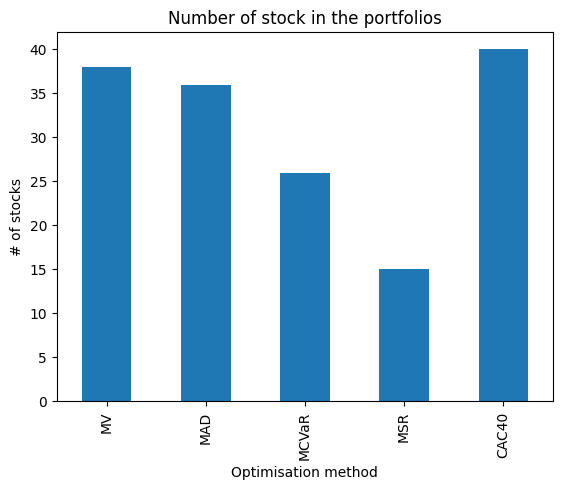

In [6]:
# Put all the weights in a df 
methods = ['MV', 'MAD', 'MCVaR','MSR']
weights = np.array([w_MV,w_MAD,w_CVaR,w_MSR]).T
weights = pd.DataFrame(weights, index=tickers, columns=methods)

# Plot it
number = (weights!=0).sum()
number['CAC40']=40
number.plot(kind='bar')
plt.title('Number of stock in the portfolios')
plt.xlabel('Optimisation method')
plt.ylabel('# of stocks')
plt.show()

A first remark is that, surprisingly, MAD picked less stocks than MV which is generally the other way. This is because volatility of stocks are much more sparse due to the power two of variance.

Move on the portfolio evolution:

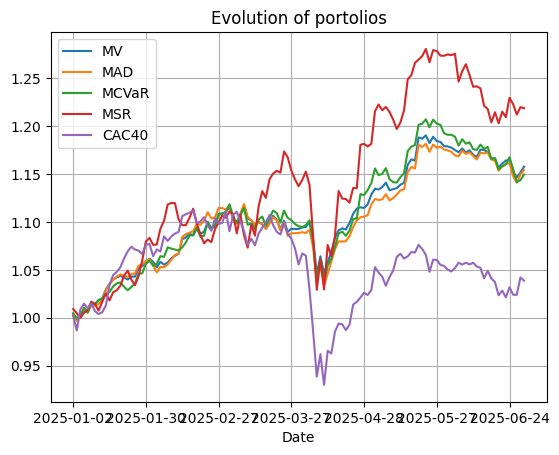

In [7]:
#Portfolios evolution + market comparison
portfolios_returns = returns_outsample@weights
portfolios_returns['CAC40'] = cac40_evolution.pct_change().dropna()
portfolios_evolution = (1+portfolios_returns).cumprod()
portfolios_evolution.plot()


plt.legend()
plt.title('Evolution of portolios')
plt.grid()
plt.show()

Here we see that the MSR allocation outperforms clearly the three others. Nevertheless, in time of crisis or big downturns, it is the one that performs the worse. This is not very surprising when we recall that the three other optimisation goals are to minimise the risk, which include being more resilient in case of market downturns.

Finally, we compute some metrics to compare the different portfolios with the market:

In [8]:
# Portfolio annualised performances
r_f = 0.024                                            # Interest rate of the French risk-free saving account
annualised_returns = 252*portfolios_returns.mean()
annualised_std = np.sqrt(252)*portfolios_returns.std()
annualised_SR = (annualised_returns - r_f) / annualised_std

# Maximum drawdown
mdd = (portfolios_evolution/portfolios_evolution.cummax()-1).min()

# VaR and CVaR: L = - r@w
loss = - portfolios_returns
var = loss.quantile(alpha)             # VaR = Q_L(0.95) = Q_r(0.05)
cvar = (loss[loss>=var]).mean()        # CVaR = E[L|L>=VaR]

# Summary of metrics
summary = np.array([number.values,annualised_returns,annualised_std,annualised_SR,mdd,var,cvar]).T
summary = pd.DataFrame(np.round(summary,4),index=methods+['CAC40'],columns=['number','return','std','SR','MDD','VaR','CVaR'])
print(summary)

       number  return     std      SR     MDD     VaR    CVaR
MV       38.0  0.3014  0.1094  2.5345 -0.0637  0.0102  0.0160
MAD      36.0  0.2958  0.1137  2.3915 -0.0759  0.0115  0.0173
MCVaR    26.0  0.2896  0.1301  2.0422 -0.0718  0.0106  0.0183
MSR      15.0  0.4234  0.2208  1.8091 -0.1231  0.0149  0.0292
CAC40    40.0  0.0940  0.1877  0.3730 -0.1637  0.0157  0.0297


It's impressive that even if the constraint was only to have a portfolio return greater that 10%, every portoflio largely outpermed this constraint. Every portfolio has a very good return but the MSR seems to be too risky compared to the others due to its high standard deviation. 

Even more surprising is that the MSR doesn't have the highest Sharpe ratio and the MCVaR one doesn't have the lowest CVaR! Let compute those metrics for the in-sample data to ensure the optimisation worked:

In [9]:
# In sample Sharpe Ratio:
in_sample_r = returns_insample@weights          # already annualised
in_sample_SR = (in_sample_r.mean()-r_f)/in_sample_r.std()

# In sample CVaR:
in_sample_loss = -in_sample_r/252               # we convert them in daily to compare with the oos metrics
in_sample_cvar = (in_sample_loss[in_sample_loss>=in_sample_loss.quantile(alpha)]).mean()        # CVaR = E[L|L>=VaR]

# IS summary
in_sample_summary = np.array([in_sample_SR,in_sample_cvar]).T
in_sample_summary = pd.DataFrame(np.round(in_sample_summary,4),index=methods,columns=['SR','CVaR'])
print(in_sample_summary)

           SR    CVaR
MV     0.0651  0.0104
MAD    0.0704  0.0105
MCVaR  0.1019  0.0090
MSR    0.2338  0.0166


This reassures us about the optimisation processes: no mistake has been made.

Taking the quick analysis into consideration, we noticed MV optimisation got the 2nd highest return behind the MSR which is way beyond the others at the cost of having the highest standard deviation as well... Thus, the classic minimum-variance optimisation seems the be the best compromise: highest Sharpe ratio and lowest value at risk and expected shortfall (CVaR). One of the cons would be the number of stocks which is the greatest as well and could be a real-implementation issue for low-bugdet portfolios such as indivuals.